# Strategy Backtesting - colab version

Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# --- USER SETTINGS ---
PROCESSED_FILE = "processed_data.csv"
BACKTEST_START = "2024-08-01"
BACKTEST_END   = "2025-07-31"
OUTDIR = "task5_outputs"
os.makedirs(OUTDIR, exist_ok=True)

initial_weights = {"TSLA": 0.10, "BND": 0.30, "SPY": 0.60} # Max Sharpe constrained

# Benchmark weights
benchmark_weights = {"SPY": 0.60, "BND": 0.40}

# Load prices
df = pd.read_csv(PROCESSED_FILE, parse_dates=["Date"], index_col="Date")
prices = pd.DataFrame({
    "TSLA": df["Close_TSLA"],
    "BND":  df["Close_BND"],
    "SPY":  df["Close_SPY"]
}).dropna().sort_index()

compute daily returns

In [2]:
# trim to backtest window
prices_bt = prices.loc[:BACKTEST_END].copy()
prices_bt = prices_bt.loc[prices_bt.index >= (pd.to_datetime(BACKTEST_START) - pd.Timedelta(days=5))]

# daily returns
rets = prices_bt.pct_change().dropna()

# select exact backtest date range
rets_bt = rets.loc[(rets.index >= BACKTEST_START) & (rets.index <= BACKTEST_END)].copy()
if rets_bt.empty:
    raise ValueError("No returns found in the requested backtest window. Check dates and business-day alignment.")

# Helper to compute portfolio returns given returns DataFrame and weight dict
def portfolio_returns(returns_df, weights):
    """returns_df: DataFrame indexed by date with asset returns columns, weights: dict mapping ticker->weight"""
    w = np.array([weights[t] for t in ["TSLA","BND","SPY"]])
    # if returns_df missing a column, fill zeros
    cols = ["TSLA","BND","SPY"]
    R = returns_df.reindex(columns=cols).fillna(0).values
    # weighted daily portfolio returns
    port_daily = R @ w
    return pd.Series(port_daily, index=returns_df.index)

Strategy A: Hold initial_weights for whole period

In [3]:
hold_daily = portfolio_returns(rets_bt, initial_weights)
hold_cum = (1 + hold_daily).cumprod()

Strategy B: Monthly rebalancing to same target weights at month start

In [4]:
# Implementation:
# - Start with value = 1.0 on the first day of backtest.
# - On first trading day of each month in the window, rebalance holdings to target weights using that day's close.
# - Then daily portfolio return is computed by weighted returns until next rebalance.
dates = rets_bt.index
months = sorted({(d.year, d.month) for d in dates})
# build a mapping from rebalance_date -> slice of returns until next rebalance
monthly_returns = []
monthly_index = []
curr_idx = 0
# create list of month start dates (first trading day in each month within backtest)
month_start_dates = []
for year, month in months:
    # first trading day for that year-month in rets_bt
    mask = [(d.year == year and d.month == month) for d in rets_bt.index]
    mm = rets_bt.index[mask]
    if len(mm) > 0:
        month_start_dates.append(mm[0])
month_start_dates = sorted(month_start_dates)

# Now simulate
value = 1.0
values = []
dates_out = []
# find mapping days->month start (rebalance trigger)
current_weights = initial_weights.copy()
for i, current_date in enumerate(rets_bt.index):
    if current_date in month_start_dates:
        # Rebalance: compute holdings needed to set portfolio weights with current prices.
        current_weights = initial_weights.copy()
    # compute today's portfolio return using current_weights
    daily_ret = (rets_bt.loc[current_date, ["TSLA","BND","SPY"]].fillna(0).values @
                np.array([current_weights["TSLA"], current_weights["BND"], current_weights["SPY"]]))
    value *= (1 + daily_ret)
    values.append(value)
    dates_out.append(current_date)

rebalance_series = pd.Series(values, index=dates_out)
rebalance_daily = rebalance_series.pct_change().fillna(0)
rebalance_cum = rebalance_series  # cumulative portfolio value series

Benchmark: static 60% SPY / 40% BND

In [5]:
# Build returns series for benchmark (use columns SPY and BND)
bench_rets_df = rets_bt[["SPY","BND"]]
bench_daily = (bench_rets_df * np.array([benchmark_weights["SPY"], benchmark_weights["BND"]])).sum(axis=1)
bench_cum = (1 + bench_daily).cumprod()

Compute statistics: total return, annualized return, annualized volatility, Sharpe

In [6]:
def stats_from_daily_returns(daily_series):
    # daily_series = daily returns, e.g., 0.01 = 1% gain
    total_return = (1 + daily_series).prod() - 1
    ann_return = daily_series.mean() * 252
    ann_vol = daily_series.std() * np.sqrt(252)
    sharpe = (ann_return - 0.0) / ann_vol if ann_vol != 0 else np.nan
    return {
        "total_return": total_return,
        "ann_return": ann_return,
        "ann_vol": ann_vol,
        "sharpe": sharpe
    }

hold_stats = stats_from_daily_returns(hold_daily)
reb_stats = stats_from_daily_returns(rebalance_daily)
bench_stats = stats_from_daily_returns(bench_daily)

Plot cumulative returns

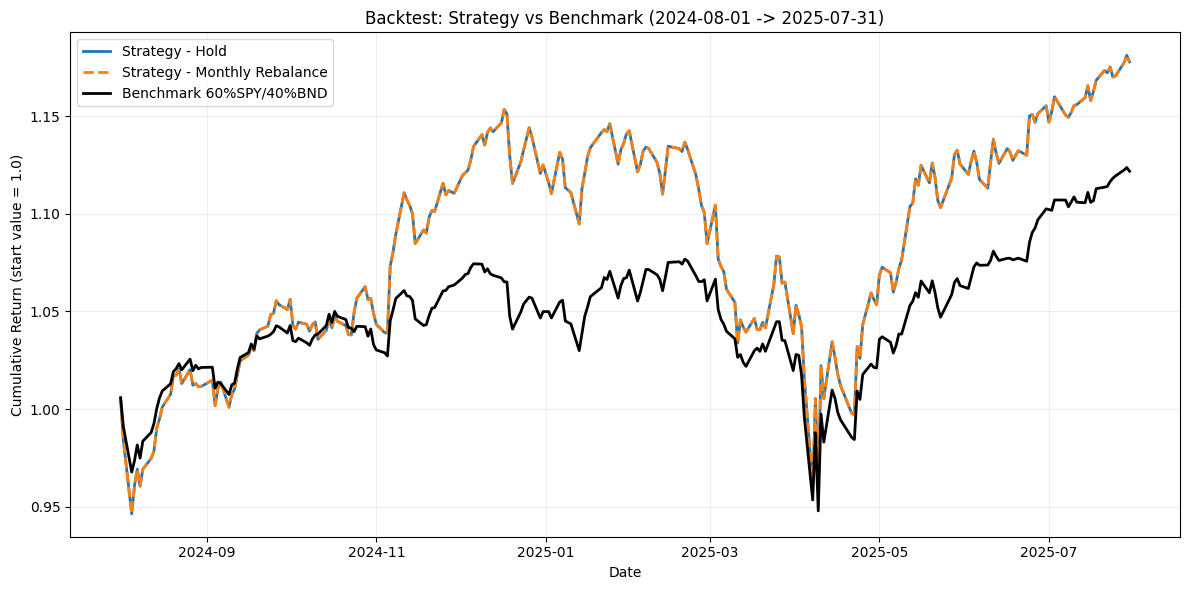

In [7]:
plt.figure(figsize=(12,6))
plt.plot(hold_cum.index, hold_cum.values, label="Strategy - Hold", linewidth=2)
plt.plot(rebalance_cum.index, rebalance_cum.values, label="Strategy - Monthly Rebalance", linewidth=2, linestyle="--")
plt.plot(bench_cum.index, bench_cum.values, label="Benchmark 60%SPY/40%BND", linewidth=2, color="k")
plt.title("Backtest: Strategy vs Benchmark ({} -> {})".format(BACKTEST_START, BACKTEST_END))
plt.ylabel("Cumulative Return (start value = 1.0)")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "backtest_cumulative.png"))
plt.show()

Print summary table

In [8]:
summary = pd.DataFrame({
    "strategy_hold": hold_stats,
    "strategy_monthly_reb": reb_stats,
    "benchmark": bench_stats
}).T
# format percentages
summary_fmt = summary.copy()
summary_fmt["total_return"] = (summary_fmt["total_return"]*100).map("{:.2f}%".format)
summary_fmt["ann_return"]   = (summary_fmt["ann_return"]*100).map("{:.2f}%".format)
summary_fmt["ann_vol"]      = (summary_fmt["ann_vol"]*100).map("{:.2f}%".format)
summary_fmt["sharpe"]       = summary_fmt["sharpe"].map("{:.2f}".format)

print("\nBacktest summary (last year):")
print(summary_fmt)


Backtest summary (last year):
                     total_return ann_return ann_vol sharpe
strategy_hold              17.79%     18.25%  18.35%   0.99
strategy_monthly_reb       17.18%     17.72%  18.35%   0.97
benchmark                  12.18%     12.49%  13.11%   0.95


In [9]:
# Save outputs
hold_cum.to_csv(os.path.join(OUTDIR, "hold_cum.csv"))
rebalance_cum.to_csv(os.path.join(OUTDIR, "rebalance_cum.csv"))
bench_cum.to_csv(os.path.join(OUTDIR, "benchmark_cum.csv"))
summary.to_csv(os.path.join(OUTDIR, "backtest_summary_raw.csv"))
print("Saved backtest outputs to:", OUTDIR)


Saved backtest outputs to: task5_outputs
